2022-05-05 19:17:58.516537: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 19:17:59.506612: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:61:00.0, compute capability: 6.1


Epoch 1/50


2022-05-05 19:18:00.893047: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


9/9 - 2s - loss: 0.3833 - binary_accuracy: 0.8545 - val_loss: 0.3327 - val_binary_accuracy: 0.9091 - 2s/epoch - 268ms/step
Epoch 2/50
9/9 - 0s - loss: 0.3259 - binary_accuracy: 0.8864 - val_loss: 0.2790 - val_binary_accuracy: 0.9091 - 49ms/epoch - 5ms/step
Epoch 3/50
9/9 - 0s - loss: 0.3023 - binary_accuracy: 0.8864 - val_loss: 0.2633 - val_binary_accuracy: 0.9091 - 50ms/epoch - 6ms/step
Epoch 4/50
9/9 - 0s - loss: 0.2850 - binary_accuracy: 0.8909 - val_loss: 0.2647 - val_binary_accuracy: 0.9091 - 118ms/epoch - 13ms/step
Epoch 5/50
9/9 - 0s - loss: 0.2783 - binary_accuracy: 0.8932 - val_loss: 0.2597 - val_binary_accuracy: 0.9091 - 87ms/epoch - 10ms/step
Epoch 6/50
9/9 - 0s - loss: 0.2674 - binary_accuracy: 0.8909 - val_loss: 0.2570 - val_binary_accuracy: 0.9091 - 49ms/epoch - 5ms/step
Epoch 7/50
9/9 - 0s - loss: 0.2644 - binary_accuracy: 0.8932 - val_loss: 0.2565 - val_binary_accuracy: 0.9091 - 56ms/epoch - 6ms/step
Epoch 8/50
9/9 - 0s - loss: 0.2582 - binary_accuracy: 0.9000 - val_los

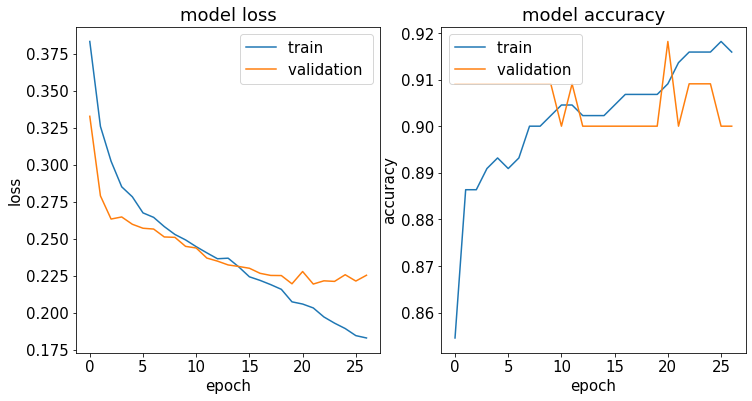

	Train: Min loss  0.183 at  26 --- Max acc  0.918 at  25 | 
	Validation : Min loss  0.219 at  21 --- Max acc  0.918 at  20 | 
-----------------------------------------------------------------------


In [1]:
import h5py
import numpy as np
import tensorflow
from keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input
import matplotlib.pyplot as plt

N_FEAT = 14
N_PART_PER_JET = 10

# Load in the datasets for training and compiling the sample weights
with h5py.File("trainingDatallp.h5", "r") as hf:
    dataset = hf["Training Data"][:]

with h5py.File("sampleDatallp.h5", "r") as hf:
    sampleData = hf["Sample Data"][:]

with h5py.File("testingDatallp.h5", "r") as hf:
    testData = hf["Testing Data"][:]

# Separate datasets into inputs and outputs, expand the dimensions of the inputs to be used with Conv1D layers
X = dataset[:, 0 : len(dataset[0]) - 1]
y = dataset[:, len(dataset[0]) - 1]
X = X.reshape((X.shape[0], N_PART_PER_JET, N_FEAT))

# Establish the sample weights
thebins = np.linspace(0, 200, 100)
bkgPts = []
sigPts = []
for i in range(len(sampleData)):
    if y[i] == 1:
        sigPts.append(sampleData[i][0])
    if y[i] == 0:
        bkgPts.append(sampleData[i][0])
bkg_counts, binsbkg = np.histogram(bkgPts, bins=thebins)
sig_counts, binssig = np.histogram(sigPts, bins=thebins)
a = []
for i in range(len(bkg_counts)):
    tempSig = float(sig_counts[i])
    tempBkg = float(bkg_counts[i])
    if tempBkg != 0:
        a.append(tempSig / tempBkg)
    if tempBkg == 0:
        a.append(0)
# Normalize the sample weights above a certain pT
for i in range(42, len(a)):
    a[i] = 0.7
    
# four-momenta of leading 20 particles
cols = [c.format(i) for i in range(20) for c in ["E_{0}",  "PX_{0}",  "PY_{0}",  "PZ_{0}"]]

# Compile the network
x = inputs = Input(shape=(N_PART_PER_JET, N_FEAT))
x = Conv1D(
    filters=50,
    kernel_size=1,
    strides=1,
    activation="relu",
)(x)
x = Conv1D(filters=50, kernel_size=1, activation="relu")(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)
x = Dense(10, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])

# Add in the sample weights, 1-to-1 correspondence with training data
# Sample weight of all signal events being equal to 1
# Sample weight of all background events being equal to the sig/bkg ratio at that jet's pT
weights = []
for i in range(len(sampleData)):
    if y[i] == 1:
        weights.append(1)
    if y[i] == 0:
        jetPt = sampleData[i][0]
        tempPt = int(jetPt / 2)
        if tempPt > 98:
            tempPt = 98
        weights.append(a[tempPt])

# Train the network
callback = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=5)
histObj = model.fit(
    X,
    y,
    epochs=50,
    batch_size=50,
    verbose=2,
    sample_weight=np.asarray(weights),
    validation_split=0.20,
    callbacks=[callback],
)

# Save the network
model.save("L1JetTagModel.h5")

#############################################################################################################
#Model Evaluation and Plot
%matplotlib inline

def plotLearningCurves(*histObjs):
    """This function processes all histories given in the tuple.
    Left losses, right accuracies
    """
    
    names=[]
    # loss plot
    plt.figure(figsize=(12,6))
    plt.rcParams.update({'font.size': 15}) #Larger font size
    plt.subplot(1,2,1)
    plt.plot(histObj.history['loss'])
    names.append('train '+histObj.name)
    plt.plot(histObj.history['val_loss'])
    names.append('validation '+histObj.name)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper right')
    

    #accuracy plot
    plt.subplot(1,2,2)
    plt.plot(histObj.history['binary_accuracy'])
    plt.plot(histObj.history['val_binary_accuracy'])
    plt.title('model accuracy')
    #plt.ylim(0.5,1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')
    
    plt.show()

    h=histObj.history
    maxIdxTrain = np.argmax(h['binary_accuracy'])
    maxIdxTest  = np.argmax(h['val_binary_accuracy'])
    minIdxTrain = np.argmin(h['loss'])
    minIdxTest  = np.argmin(h['val_loss'])
    
    strg='\tTrain: Min loss {:6.3f} at {:3d} --- Max acc {:6.3f} at {:3d} | '+histObj.name
    print(strg.format(h['loss'][minIdxTrain],minIdxTrain,h['binary_accuracy'][maxIdxTrain],maxIdxTrain))
    strg='\tValidation : Min loss {:6.3f} at {:3d} --- Max acc {:6.3f} at {:3d} | '+histObj.name
    print(strg.format(h['val_loss'][minIdxTest],minIdxTest,h['val_binary_accuracy'][maxIdxTest],maxIdxTest))
    print(len(strg)*'-')

histObj.name='' # name added to legend
plotLearningCurves(histObj) # the above defined function to plot learning curves
